In [ ]:
# ============================================================================
# CELL 1: SETUP AND INSTALLATION (WITH AUTO-RESTART)
# ============================================================================
print("="*80)
print("SAND CHALLENGE - HUBERT BASELINE (STATE-OF-THE-ART)")
print("="*80)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install required packages
print("\n[1/7] Installing required packages...")
print("⏱ This will take 2-3 minutes...")

# Uninstall conflicting packages first
!pip uninstall -y transformers huggingface_hub tokenizers

# Install fresh compatible versions
!pip install transformers==4.40.0 -q
!pip install torch torchaudio -q
!pip install scikit-learn pandas numpy -q
!pip install librosa soundfile -q
!pip install optuna -q
!pip install matplotlib seaborn -q
!pip install imbalanced-learn -q  # ⭐ ADDED FOR SMOTE

print("✅ Installation complete!")
print("🔄 Restarting runtime...")

# Automatic restart
import os
os.kill(os.getpid(), 9)

SAND CHALLENGE - HUBERT BASELINE (STATE-OF-THE-ART)
Mounted at /content/drive

[1/7] Installing required packages...
⏱ This will take 2-3 minutes...
Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
Found existing installation: huggingface-hub 0.36.0
Uninstalling huggingface-hub-0.36.0:
  Successfully uninstalled huggingface-hub-0.36.0
Found existing installation: tokenizers 0.22.1
Uninstalling tokenizers-0.22.1:
  Successfully uninstalled tokenizers-0.22.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 43.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the

In [1]:
# ============================================================================
# CELL 2: IMPORTS (RUN AFTER RESTART)
# ============================================================================
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
import torchaudio
import librosa
import soundfile as sf
from scipy.stats import skew, kurtosis

from transformers import (
    HubertModel,
    AutoFeatureExtractor
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, cohen_kappa_score
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm.auto import tqdm
import joblib
import json

# Mount Drive again after restart
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

# Set random seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print("✅ All imports successful!")

Mounted at /content/drive
✅ Using device: cuda
✅ All imports successful!


In [2]:
# ============================================================================
# CELL 3: CONFIGURATION
# ============================================================================
class Config:
    """Configuration for HuBERT baseline"""

    # Paths
    BASE_PATH = '/content/drive/MyDrive/SAND_Project_Data'
    TRAINING_PATH = os.path.join(BASE_PATH, 'training')
    EXCEL_PATH = os.path.join(BASE_PATH, 'sand_task_1.xlsx')
    OUTPUT_PATH = os.path.join(BASE_PATH, 'hubert_baseline_results')

    # Sheet names
    SHEET_TRAINING_BASELINE = 'Training Baseline - Task 1'
    SHEET_VALIDATION_BASELINE = 'Validation Baseline - Task 1'

    # Audio types
    AUDIO_TYPES = ['phonationA', 'phonationE', 'phonationI', 'phonationO', 'phonationU',
                   'rhythmKA', 'rhythmPA', 'rhythmTA']

    # HuBERT Model Configuration
    HUBERT_MODEL = 'facebook/hubert-base-ls960'
    MAX_AUDIO_LENGTH = 16000 * 17  # 17 seconds max
    SAMPLING_RATE = 16000

    # Feature extraction strategy
    POOLING_STRATEGY = 'mean'
    USE_ALL_LAYERS = False
    LAYER_TO_USE = -1

    # Classifier Configuration
    CLASSIFIER = 'svm'

    # Training parameters
    BATCH_SIZE = 8
    N_FOLDS = 5
    RANDOM_SEED = 42

    # ⭐ SMOTE Configuration
    USE_SMOTE = True  # Set to True to use SMOTE
    SMOTE_K_NEIGHBORS = 3  # Number of neighbors for SMOTE (must be < smallest class size)
    SMOTE_SAMPLING_STRATEGY = 'auto'  # 'auto' or dict like {0: 50, 1: 50}

    # Class names (0-indexed)
    CLASS_NAMES = {
        0: 'Severe Dysarthria',
        1: 'Moderate Dysarthria',
        2: 'Mild Dysarthria',
        3: 'No Dysarthria (ALS)',
        4: 'Healthy'
    }

config = Config()

# Create output directory
os.makedirs(config.OUTPUT_PATH, exist_ok=True)
print(f"\n✅ Output directory: {config.OUTPUT_PATH}")

# Verify paths
print(f"\n🔍 Verifying paths...")
print(f"   Base path exists: {os.path.exists(config.BASE_PATH)}")
print(f"   Training path exists: {os.path.exists(config.TRAINING_PATH)}")
print(f"   Excel file exists: {os.path.exists(config.EXCEL_PATH)}")

if not all([os.path.exists(config.BASE_PATH),
            os.path.exists(config.TRAINING_PATH),
            os.path.exists(config.EXCEL_PATH)]):
    raise FileNotFoundError("Required paths not found!")

print(f"\n📋 Configuration:")
print(f"   HuBERT Model: {config.HUBERT_MODEL}")
print(f"   Pooling Strategy: {config.POOLING_STRATEGY}")
print(f"   Classifier: {config.CLASSIFIER}")
print(f"   Use SMOTE: {config.USE_SMOTE}")  # ⭐ ADDED
print(f"   Device: {device}")


✅ Output directory: /content/drive/MyDrive/SAND_Project_Data/hubert_baseline_results

🔍 Verifying paths...
   Base path exists: True
   Training path exists: True
   Excel file exists: True

📋 Configuration:
   HuBERT Model: facebook/hubert-base-ls960
   Pooling Strategy: mean
   Classifier: svm
   Use SMOTE: True
   Device: cuda


In [3]:
# ============================================================================
# CELL 4: LOAD DATA
# ============================================================================
print("\n[2/7] Loading dataset...")

def load_data(excel_path, sheet_name):
    """Load dataset from Excel"""
    df = pd.read_excel(excel_path, sheet_name=sheet_name)
    print(f"   ✅ Loaded {len(df)} samples from: '{sheet_name}'")

    # Convert to 0-indexed classes
    df['Class'] = df['Class'] - 1

    # Display distribution
    class_dist = df['Class'].value_counts().sort_index()
    print(f"   📊 Class distribution:")
    for cls, count in class_dist.items():
        pct = (count / len(df)) * 100
        print(f"      Class {cls} ({config.CLASS_NAMES[cls]}): {count:3d} ({pct:5.2f}%)")

    return df

# Load datasets
print("\n📊 Loading data sheets...")
df_train = load_data(config.EXCEL_PATH, config.SHEET_TRAINING_BASELINE)
print()
df_val = load_data(config.EXCEL_PATH, config.SHEET_VALIDATION_BASELINE)

print(f"\n📈 Dataset Summary:")
print(f"   Training samples: {len(df_train):3d}")
print(f"   Validation samples: {len(df_val):3d}")
print(f"   Total audio files: {(len(df_train) + len(df_val)) * len(config.AUDIO_TYPES)}")

# Verify no overlap
train_ids = set(df_train['ID'].values)
val_ids = set(df_val['ID'].values)
overlap = train_ids.intersection(val_ids)
print(f"   Overlap check: {'✅ No overlap' if len(overlap) == 0 else f'⚠ {len(overlap)} overlaps'}")



[2/7] Loading dataset...

📊 Loading data sheets...
   ✅ Loaded 219 samples from: 'Training Baseline - Task 1'
   📊 Class distribution:
      Class 0 (Severe Dysarthria):   4 ( 1.83%)
      Class 1 (Moderate Dysarthria):  22 (10.05%)
      Class 2 (Mild Dysarthria):  45 (20.55%)
      Class 3 (No Dysarthria (ALS)):  62 (28.31%)
      Class 4 (Healthy):  86 (39.27%)

   ✅ Loaded 53 samples from: 'Validation Baseline - Task 1'
   📊 Class distribution:
      Class 0 (Severe Dysarthria):   2 ( 3.77%)
      Class 1 (Moderate Dysarthria):   4 ( 7.55%)
      Class 2 (Mild Dysarthria):  12 (22.64%)
      Class 3 (No Dysarthria (ALS)):  14 (26.42%)
      Class 4 (Healthy):  21 (39.62%)

📈 Dataset Summary:
   Training samples: 219
   Validation samples:  53
   Total audio files: 2176
   Overlap check: ✅ No overlap


In [4]:
# ============================================================================
# CELL 5: LOAD HUBERT MODEL (MODIFIED - Save reference immediately)
# ============================================================================
print(f"\n[3/7] Loading HuBERT model: {config.HUBERT_MODEL}")
print("⏱ This may take 1-2 minutes for first-time download...")

# Load feature extractor and model
feature_extractor = AutoFeatureExtractor.from_pretrained(config.HUBERT_MODEL)
model = HubertModel.from_pretrained(config.HUBERT_MODEL)
model = model.to(device)
model.eval()  # Set to evaluation mode

# ⭐ SAVE MODEL REFERENCE FOR LATER USE
hubert_model_original = model

print(f"✅ Model loaded successfully!")
print(f"   Model size: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M parameters")
print(f"   Hidden size: {model.config.hidden_size}")
print(f"   Number of layers: {model.config.num_hidden_layers}")
print(f"   Sampling rate: {feature_extractor.sampling_rate} Hz")



[3/7] Loading HuBERT model: facebook/hubert-base-ls960
⏱ This may take 1-2 minutes for first-time download...


preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

✅ Model loaded successfully!
   Model size: 94.4M parameters
   Hidden size: 768
   Number of layers: 12
   Sampling rate: 16000 Hz


In [5]:
# ============================================================================
# CELL 6: AUDIO PROCESSING FUNCTIONS
# ============================================================================
def load_audio(audio_path, target_sr=16000, max_length=None):
    """
    Load and preprocess audio file
    Args:
        audio_path: Path to audio file
        target_sr: Target sampling rate
        max_length: Maximum audio length in samples
    Returns:
        audio: Audio waveform as numpy array
        sr: Sampling rate
    """
    try:
        # Load audio
        audio, sr = librosa.load(audio_path, sr=target_sr, mono=True)

        # Trim silence
        audio, _ = librosa.effects.trim(audio, top_db=20)

        # Limit length if specified
        if max_length and len(audio) > max_length:
            audio = audio[:max_length]

        # Ensure minimum length (1 second)
        min_length = target_sr
        if len(audio) < min_length:
            audio = np.pad(audio, (0, min_length - len(audio)), mode='constant')

        return audio, sr

    except Exception as e:
        print(f"  ⚠ Error loading {audio_path}: {str(e)}")
        # Return silence
        return np.zeros(target_sr), target_sr

def extract_spectral_features(audio, sr=16000):
    """
    Extract comprehensive spectral features from audio

    Args:
        audio: Audio waveform
        sr: Sampling rate

    Returns:
        features: Array of spectral features
    """
    features = []

    # 1. Original spectral features (6 features)
    spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    features.extend([np.mean(spectral_centroids), np.std(spectral_centroids)])

    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    features.extend([np.mean(spectral_rolloff), np.std(spectral_rolloff)])

    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
    features.extend([np.mean(spectral_bandwidth), np.std(spectral_bandwidth)])

    # 2. Spectral Flatness (3 features) - HIGHLY RECOMMENDED
    spectral_flatness = librosa.feature.spectral_flatness(y=audio)[0]
    features.extend([
        np.mean(spectral_flatness),
        np.std(spectral_flatness),
        np.max(spectral_flatness)
    ])

    return np.array(features)

def extract_hubert_features(audio, sampling_rate=16000, pooling='mean'):
    """
    Extract HuBERT features from audio

    Args:
        audio: Audio waveform (numpy array)
        sampling_rate: Sampling rate
        pooling: Pooling strategy ('mean', 'max', 'mean+max', 'last')

    Returns:
        features: Extracted features as numpy array
    """
    try:
        # Preprocess audio
        inputs = feature_extractor(
            audio,
            sampling_rate=sampling_rate,
            return_tensors="pt",
            padding=True
        )

        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Extract features
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Get hidden states
        if config.USE_ALL_LAYERS:
            # Use all hidden layers
            hidden_states = outputs.hidden_states
            features = torch.stack(hidden_states, dim=0).mean(dim=0)
        else:
            # Use specific layer
            features = outputs.hidden_states[config.LAYER_TO_USE]

        # Apply pooling
        if pooling == 'mean':
            features = features.mean(dim=1)
        elif pooling == 'max':
            features = features.max(dim=1)[0]
        elif pooling == 'mean+max':
            mean_pool = features.mean(dim=1)
            max_pool = features.max(dim=1)[0]
            features = torch.cat([mean_pool, max_pool], dim=-1)
        elif pooling == 'last':
            features = features[:, -1, :]
        else:
            features = features.mean(dim=1)

        # Convert to numpy
        features = features.cpu().numpy().squeeze()

        return features

    except Exception as e:
        print(f"  ⚠ Error extracting features: {str(e)}")
        # Return zero features
        feature_dim = model.config.hidden_size
        if pooling == 'mean+max':
            feature_dim *= 2
        return np.zeros(feature_dim)

print("✅ Audio processing functions defined!")

✅ Audio processing functions defined!


In [6]:
# ============================================================================
# CELL 7: EXTRACT FEATURES FROM ALL AUDIO FILES
# ============================================================================
print(f"\n[4/7] Extracting HuBERT features...")
print(f"  Strategy: {config.POOLING_STRATEGY} pooling")
print(f"  Processing {len(df_train)} training + {len(df_val)} validation samples")
print(f"  Total: {(len(df_train) + len(df_val)) * len(config.AUDIO_TYPES)} audio files")

def extract_features_for_dataset(df, dataset_path, audio_types):
    """
    Extract HuBERT + Spectral features for entire dataset

    Args:
        df: DataFrame with patient IDs and labels
        dataset_path: Path to audio files
        audio_types: List of audio types to process

    Returns:
        X: Feature matrix
        y: Labels
        ids: Patient IDs
    """
    features_list = []
    labels_list = []
    ids_list = []

    print(f"\n  Processing {len(df)} patients...")

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="  Extracting"):
        patient_id = row['ID']
        patient_class = row['Class']

        patient_features = []

        # Process all audio types for this patient
        for audio_type in audio_types:
            audio_file = f"{patient_id}_{audio_type}.wav"
            audio_path = os.path.join(dataset_path, audio_type, audio_file)

            if os.path.exists(audio_path):
                # Load audio
                audio, sr = load_audio(
                    audio_path,
                    target_sr=config.SAMPLING_RATE,
                    max_length=config.MAX_AUDIO_LENGTH
                )

                # Extract HuBERT features
                hubert_features = extract_hubert_features(
                    audio,
                    sampling_rate=sr,
                    pooling=config.POOLING_STRATEGY
                )

                # Extract spectral features
                spectral_features = extract_spectral_features(audio, sr)

                # Concatenate HuBERT + Spectral features
                combined_features = np.concatenate([hubert_features, spectral_features])

                patient_features.append(combined_features)
            else:
                # Use zero features for missing files
                feature_dim = model.config.hidden_size
                if config.POOLING_STRATEGY == 'mean+max':
                    feature_dim *= 2
                # Add 9 for spectral features (6 + 3)
                feature_dim += 9
                patient_features.append(np.zeros(feature_dim))

        # Concatenate features from all audio types
        combined_features = np.concatenate(patient_features)
        features_list.append(combined_features)
        labels_list.append(patient_class)
        ids_list.append(patient_id)

    X = np.array(features_list)
    y = np.array(labels_list)
    ids = np.array(ids_list)

    return X, y, ids

# Extract features for training set
print("\n🎵 Extracting TRAINING features...")
X_train, y_train, ids_train = extract_features_for_dataset(
    df_train,
    config.TRAINING_PATH,
    config.AUDIO_TYPES
)

# Extract features for validation set
print("\n🎵 Extracting VALIDATION features...")
X_val, y_val, ids_val = extract_features_for_dataset(
    df_val,
    config.TRAINING_PATH,
    config.AUDIO_TYPES
)

print(f"\n✅ Feature extraction complete!")
print(f"  Training: X={X_train.shape}, y={y_train.shape}")
print(f"  Validation: X={X_val.shape}, y={y_val.shape}")

# Save raw features
features_path = os.path.join(config.OUTPUT_PATH, 'hubert_features.npz')
np.savez(
    features_path,
    X_train=X_train, y_train=y_train, ids_train=ids_train,
    X_val=X_val, y_val=y_val, ids_val=ids_val
)
print(f"  💾 Features saved to: {features_path}")

# Clear GPU memory
torch.cuda.empty_cache()


[4/7] Extracting HuBERT features...
  Strategy: mean pooling
  Processing 219 training + 53 validation samples
  Total: 2176 audio files

🎵 Extracting TRAINING features...

  Processing 219 patients...


  Extracting:   0%|          | 0/219 [00:00<?, ?it/s]


🎵 Extracting VALIDATION features...

  Processing 53 patients...


  Extracting:   0%|          | 0/53 [00:00<?, ?it/s]


✅ Feature extraction complete!
  Training: X=(219, 6216), y=(219,)
  Validation: X=(53, 6216), y=(53,)
  💾 Features saved to: /content/drive/MyDrive/SAND_Project_Data/hubert_baseline_results/hubert_features.npz


In [7]:
# ============================================================================
# CELL 8: PREPROCESS FEATURES
# ============================================================================
print("\n[5/7] Preprocessing features...")

# Check for problematic values
print(f"   🔍 Data quality check:")
print(f"      NaN in X_train: {np.isnan(X_train).sum()}")
print(f"      Inf in X_train: {np.isinf(X_train).sum()}")
print(f"      NaN in X_val: {np.isnan(X_val).sum()}")
print(f"      Inf in X_val: {np.isinf(X_val).sum()}")

# Clean data
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)

# Standardize features
print(f"\n   🔧 Standardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"   ✅ Features standardized")
print(f"      Training - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")
print(f"      Validation - Mean: {X_val_scaled.mean():.6f}, Std: {X_val_scaled.std():.6f}")

# Save scaler
scaler_path = os.path.join(config.OUTPUT_PATH, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"   💾 Scaler saved to: {scaler_path}")

# Display feature statistics
print(f"\n   📊 Feature Statistics:")
print(f"      Feature dimension: {X_train_scaled.shape[1]}")
print(f"      Min value: {X_train_scaled.min():.4f}")
print(f"      Max value: {X_train_scaled.max():.4f}")
print(f"      Mean: {X_train_scaled.mean():.4f}")
print(f"      Std: {X_train_scaled.std():.4f}")


[5/7] Preprocessing features...
   🔍 Data quality check:
      NaN in X_train: 0
      Inf in X_train: 0
      NaN in X_val: 0
      Inf in X_val: 0

   🔧 Standardizing features...
   ✅ Features standardized
      Training - Mean: 0.000000, Std: 1.000000
      Validation - Mean: 0.019462, Std: 8.833868
   💾 Scaler saved to: /content/drive/MyDrive/SAND_Project_Data/hubert_baseline_results/scaler.pkl

   📊 Feature Statistics:
      Feature dimension: 6216
      Min value: -6.1489
      Max value: 14.7648
      Mean: 0.0000
      Std: 1.0000


In [8]:
# ============================================================================
# CELL 8.5: STANDARD SMOTE
# ============================================================================
if config.USE_SMOTE:
    print("\n[5.5/7] Applying standard SMOTE...")

    print(f"\n 📊 Original class distribution:")
    unique, counts = np.unique(y_train, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"   Class {cls} ({config.CLASS_NAMES[cls]:25s}): {count:3d} samples")

    min_class_size = min(counts)
    k_neighbors = min(config.SMOTE_K_NEIGHBORS, min_class_size - 1)

    if k_neighbors < 1:
        print(f"\n ⚠️  Insufficient samples for SMOTE.")
        X_train_resampled = X_train_scaled
        y_train_resampled = y_train
    else:
        try:
            smote = SMOTE(
                sampling_strategy='auto',
                k_neighbors=k_neighbors,
                random_state=config.RANDOM_SEED
            )

            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

            print(f"\n ✅ SMOTE applied!")
            unique_new, counts_new = np.unique(y_train_resampled, return_counts=True)
            for cls, count in zip(unique_new, counts_new):
                print(f"   Class {cls} ({config.CLASS_NAMES[cls]:25s}): {count:3d} samples")

        except Exception as e:
            print(f"\n ⚠️  Error: {str(e)}")
            X_train_resampled = X_train_scaled
            y_train_resampled = y_train
else:
    X_train_resampled = X_train_scaled
    y_train_resampled = y_train

X_val_scaled_final = X_val_scaled
y_val_final = y_val

print(f"\n ✅ Ready for training: {len(y_train_resampled)} samples")


[5.5/7] Applying standard SMOTE...

 📊 Original class distribution:
   Class 0 (Severe Dysarthria        ):   4 samples
   Class 1 (Moderate Dysarthria      ):  22 samples
   Class 2 (Mild Dysarthria          ):  45 samples
   Class 3 (No Dysarthria (ALS)      ):  62 samples
   Class 4 (Healthy                  ):  86 samples

 ✅ SMOTE applied!
   Class 0 (Severe Dysarthria        ):  86 samples
   Class 1 (Moderate Dysarthria      ):  86 samples
   Class 2 (Mild Dysarthria          ):  86 samples
   Class 3 (No Dysarthria (ALS)      ):  86 samples
   Class 4 (Healthy                  ):  86 samples

 ✅ Ready for training: 430 samples


In [9]:
# ============================================================================
# CELL 9: TRAIN ENSEMBLE WITH MULTIPLE STRATEGIES
# ============================================================================
print(f"\n[6/7] Training ensemble of classifiers with different Class 0 strategies...")

from sklearn.ensemble import VotingClassifier

# Strategy 1: Balanced SVM
print(f"\n 📦 Model 1: Balanced SVM")
clf1 = SVC(
    kernel='rbf',
    C=10.0,
    gamma='scale',
    random_state=config.RANDOM_SEED,
    class_weight='balanced',
    probability=True
)

# Strategy 2: Class 0 weighted 5x
print(f" 📦 Model 2: SVM with 5x Class 0 weight")
clf2 = SVC(
    kernel='rbf',
    C=10.0,
    gamma='scale',
    random_state=config.RANDOM_SEED + 1,
    class_weight={0: 5.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0},
    probability=True
)

# Strategy 3: Random Forest with balanced weights
print(f" 📦 Model 3: Balanced Random Forest")
clf3 = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    random_state=config.RANDOM_SEED,
    class_weight='balanced',
    n_jobs=-1
)

# Strategy 4: Logistic Regression with Class 0 weighted 5x
print(f" 📦 Model 4: Logistic Regression with 5x Class 0 weight")
clf4 = LogisticRegression(
    max_iter=1000,
    random_state=config.RANDOM_SEED,
    class_weight={0: 5.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0},
    C=1.0
)

# Train all models
print(f"\n 🎯 Training all models...")
models = [clf1, clf2, clf3, clf4]
model_names = ['Balanced SVM', 'Weighted SVM', 'RF', 'LogReg']

for i, (model, name) in enumerate(zip(models, model_names), 1):
    model.fit(X_train_resampled, y_train_resampled)
    print(f"   ✅ Model {i} ({name}) trained")

# Create voting classifier (soft voting uses probabilities)
print(f"\n 🗳️  Creating voting ensemble...")
classifier = VotingClassifier(
    estimators=[
        ('svm_balanced', clf1),
        ('svm_weighted', clf2),
        ('rf', clf3),
        ('logreg', clf4)
    ],
    voting='soft',
    weights=[1, 2, 1, 1]  # Give weighted SVM 2x influence
)

# Fit the ensemble (quick since models already trained)
classifier.fit(X_train_resampled, y_train_resampled)
print(f"   ✅ Ensemble ready!")

# Cross-validation
from sklearn.model_selection import cross_val_score
print(f"\n 📊 Cross-validation on ensemble...")
cv_scores = cross_val_score(
    classifier,
    X_train_resampled,
    y_train_resampled,
    cv=config.N_FOLDS,
    scoring='f1_macro',
    n_jobs=-1
)

print(f"   Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Save models
model_path = os.path.join(config.OUTPUT_PATH, 'ensemble_classifier.pkl')
joblib.dump(classifier, model_path)
print(f"\n 💾 Ensemble saved to: {model_path}")

# Store individual models for analysis
config.INDIVIDUAL_MODELS = models
config.MODEL_NAMES = model_names


[6/7] Training ensemble of classifiers with different Class 0 strategies...

 📦 Model 1: Balanced SVM
 📦 Model 2: SVM with 5x Class 0 weight
 📦 Model 3: Balanced Random Forest
 📦 Model 4: Logistic Regression with 5x Class 0 weight

 🎯 Training all models...
   ✅ Model 1 (Balanced SVM) trained
   ✅ Model 2 (Weighted SVM) trained
   ✅ Model 3 (RF) trained
   ✅ Model 4 (LogReg) trained

 🗳️  Creating voting ensemble...
   ✅ Ensemble ready!

 📊 Cross-validation on ensemble...
   Mean CV F1: 0.8247 (+/- 0.0394)

 💾 Ensemble saved to: /content/drive/MyDrive/SAND_Project_Data/hubert_baseline_results/ensemble_classifier.pkl


In [10]:
# ============================================================================
# CELL 10: ENSEMBLE PREDICTION WITH CLASS 0 BOOSTING
# ============================================================================
print("\n[7/7] Evaluating ensemble with Class 0 boosting...")

# Get predictions from each individual model
print(f"\n 🔍 Getting predictions from all models...")
individual_predictions = []
individual_probas = []

for model, name in zip(config.INDIVIDUAL_MODELS, config.MODEL_NAMES):
    pred = model.predict(X_val_scaled_final)
    proba = model.predict_proba(X_val_scaled_final)
    individual_predictions.append(pred)
    individual_probas.append(proba)

    class_0_count = np.sum(pred == 0)
    print(f"   {name}: predicted {class_0_count} Class 0 samples")

# Get ensemble prediction
print(f"\n 🗳️  Getting ensemble prediction...")
y_val_pred_ensemble = classifier.predict(X_val_scaled_final)
y_val_proba_ensemble = classifier.predict_proba(X_val_scaled_final)

print(f"   Ensemble: predicted {np.sum(y_val_pred_ensemble == 0)} Class 0 samples")

# AGGRESSIVE CLASS 0 DETECTION RULE:
# If ANY two models predict Class 0, override to Class 0
print(f"\n 🚀 Applying aggressive Class 0 detection rule...")
print(f"   Rule: If 2+ models predict Class 0 → Force Class 0")

y_val_pred_final = y_val_pred_ensemble.copy()

for i in range(len(y_val_pred_final)):
    # Count how many models predicted Class 0 for this sample
    class_0_votes = sum([pred[i] == 0 for pred in individual_predictions])

    if class_0_votes >= 2:  # If 2 or more models say Class 0
        y_val_pred_final[i] = 0

final_class_0_count = np.sum(y_val_pred_final == 0)
print(f"   Final Class 0 predictions after rule: {final_class_0_count}")
print(f"   True Class 0 samples: {np.sum(y_val_final == 0)}")

# Compute metrics
accuracy = accuracy_score(y_val_final, y_val_pred_final)
f1_macro = f1_score(y_val_final, y_val_pred_final, average='macro')
f1_weighted = f1_score(y_val_final, y_val_pred_final, average='weighted')
precision = precision_score(y_val_final, y_val_pred_final, average='macro', zero_division=0)
recall = recall_score(y_val_final, y_val_pred_final, average='macro', zero_division=0)
kappa = cohen_kappa_score(y_val_final, y_val_pred_final)

print("\n" + "="*80)
print("🎯 VALIDATION RESULTS - ENSEMBLE WITH CLASS 0 BOOSTING")
print("="*80)
print(f"Accuracy:              {accuracy:.4f}")
print(f"F1 Score (Macro):      {f1_macro:.4f} ⭐ Main SAND metric")
print(f"F1 Score (Weighted):   {f1_weighted:.4f}")
print(f"Precision (Macro):     {precision:.4f}")
print(f"Recall (Macro):        {recall:.4f}")
print(f"Cohen's Kappa:         {kappa:.4f}")

# Per-class metrics
print("\n" + "-"*80)
print("PER-CLASS METRICS")
print("-"*80)
available_classes = sorted(np.unique(y_val_final))
class_labels = [config.CLASS_NAMES[int(i)] for i in available_classes]
print(classification_report(y_val_final, y_val_pred_final, target_names=class_labels, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_val_final, y_val_pred_final)
print("\nConfusion Matrix:")
print(cm)

# Per-class F1
f1_per_class = f1_score(y_val_final, y_val_pred_final, average=None, zero_division=0)
print("\nF1 Score per Class:")
for cls, f1_val in zip(available_classes, f1_per_class):
    label_name = config.CLASS_NAMES[int(cls)]
    print(f"   Class {cls} ({label_name:25s}): {f1_val:.4f}")

# Detailed Class 0 analysis
print("\n" + "="*80)
print("🔬 CLASS 0 DETECTION DETAILS")
print("="*80)
class_0_mask = y_val_final == 0
if np.sum(class_0_mask) > 0:
    print(f"True Class 0 samples: {np.sum(class_0_mask)}")
    print(f"Correctly predicted: {np.sum((y_val_pred_final == 0) & class_0_mask)}")

    print(f"\nVoting breakdown for true Class 0 samples:")
    for idx in np.where(class_0_mask)[0]:
        votes = [pred[idx] for pred in individual_predictions]
        class_0_votes = sum([v == 0 for v in votes])
        print(f"   Sample {idx}: {class_0_votes}/4 models voted Class 0 - {votes} → {y_val_pred_final[idx]}")

# Save results
results = {
    'model': 'HuBERT + SMOTE + Ensemble (4 models) + Class 0 Boosting',
    'accuracy': float(accuracy),
    'f1_macro': float(f1_macro),
    'f1_weighted': float(f1_weighted),
    'cv_mean': float(cv_scores.mean()),
    'f1_per_class': {int(cls): float(f1_val) for cls, f1_val in zip(available_classes, f1_per_class)},
    'confusion_matrix': cm.tolist(),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

results_path = os.path.join(config.OUTPUT_PATH, 'results_ensemble.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)

print(f"\n💾 Results saved to: {results_path}")


[7/7] Evaluating ensemble with Class 0 boosting...

 🔍 Getting predictions from all models...
   Balanced SVM: predicted 0 Class 0 samples
   Weighted SVM: predicted 0 Class 0 samples
   RF: predicted 0 Class 0 samples
   LogReg: predicted 3 Class 0 samples

 🗳️  Getting ensemble prediction...
   Ensemble: predicted 1 Class 0 samples

 🚀 Applying aggressive Class 0 detection rule...
   Rule: If 2+ models predict Class 0 → Force Class 0
   Final Class 0 predictions after rule: 1
   True Class 0 samples: 2

🎯 VALIDATION RESULTS - ENSEMBLE WITH CLASS 0 BOOSTING
Accuracy:              0.6415
F1 Score (Macro):      0.6505 ⭐ Main SAND metric
F1 Score (Weighted):   0.6344
Precision (Macro):     0.7211
Recall (Macro):        0.6214
Cohen's Kappa:         0.4888

--------------------------------------------------------------------------------
PER-CLASS METRICS
--------------------------------------------------------------------------------
                     precision    recall  f1-score   s


📊 GENERATING VISUALIZATIONS

📈 Creating confusion matrix visualization...
📈 Creating normalized confusion matrix...
📈 Creating per-class F1 score bar chart...
📈 Creating precision/recall/F1 comparison...
📈 Creating class distribution comparison...

💾 Visualization saved to: /content/drive/MyDrive/SAND_Project_Data/hubert_baseline_results/validation_visualization.png


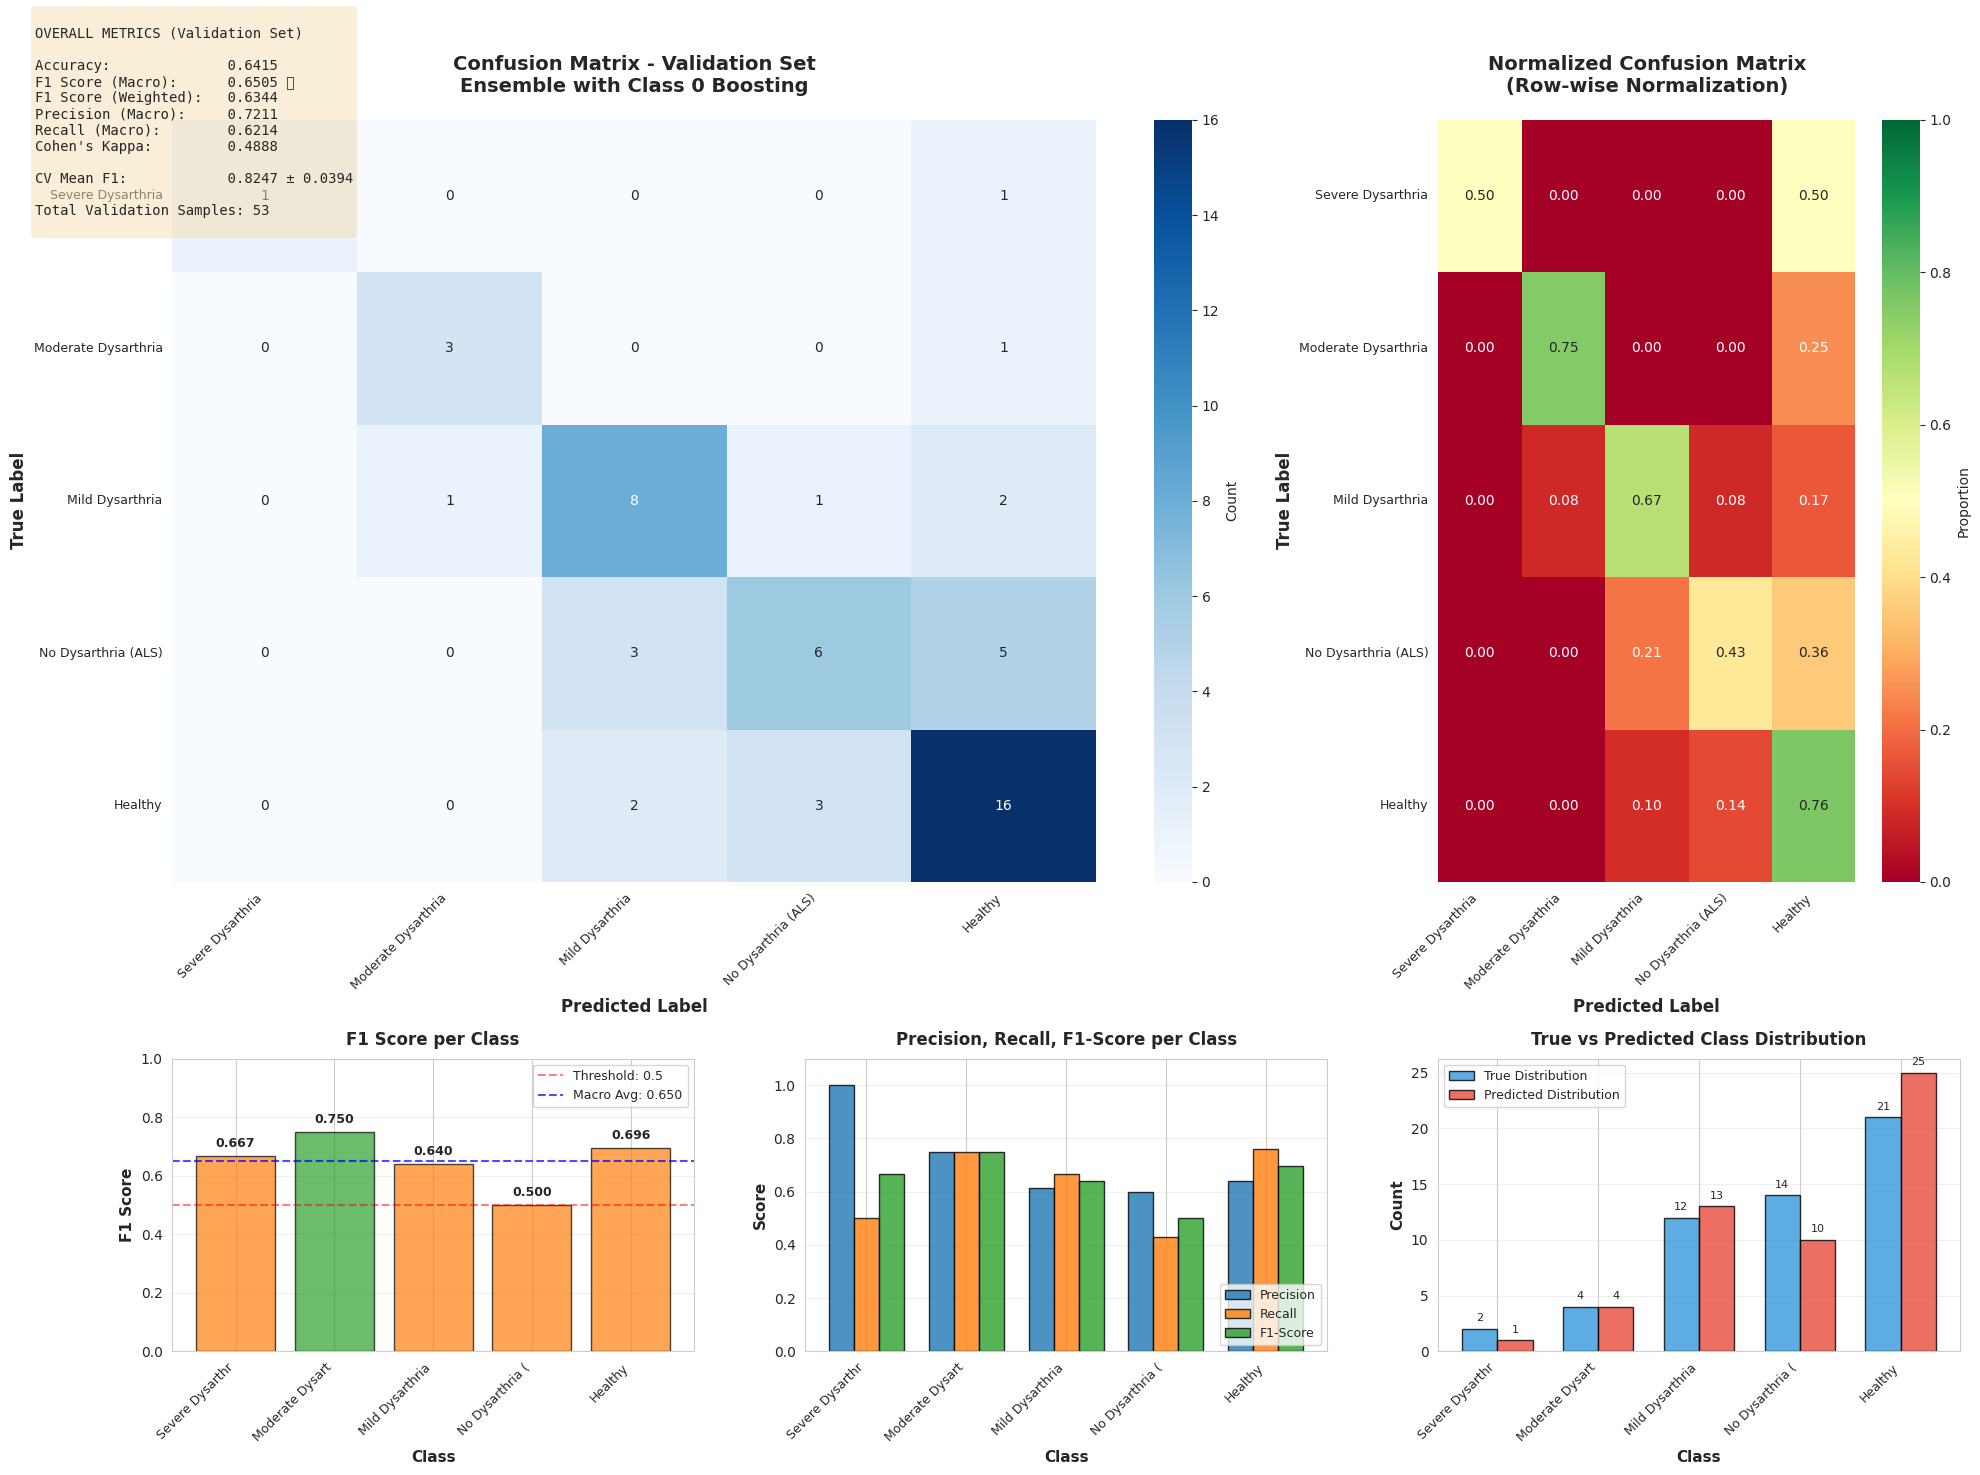


✅ VISUALIZATIONS COMPLETE

📊 Creating individual model comparison...
💾 Individual models visualization saved to: /content/drive/MyDrive/SAND_Project_Data/hubert_baseline_results/individual_models_comparison.png


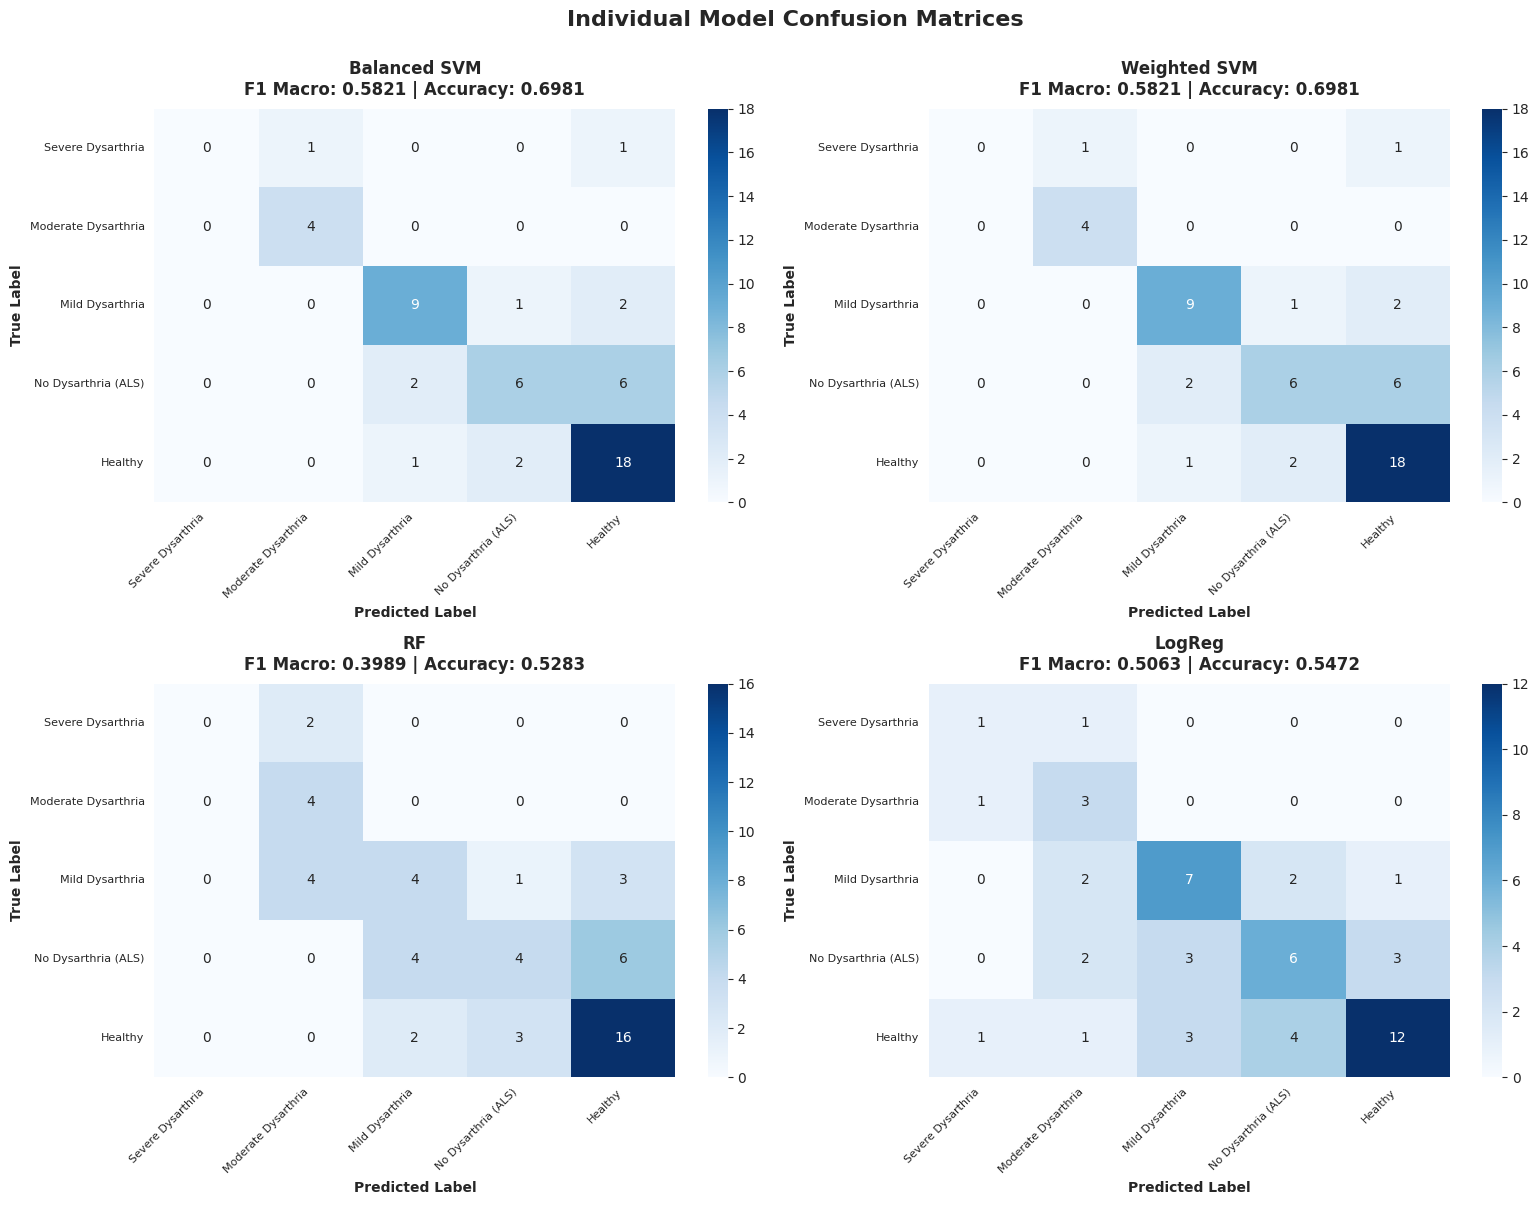


📊 Creating Class 0 detection analysis...
💾 Class 0 analysis saved to: /content/drive/MyDrive/SAND_Project_Data/hubert_baseline_results/class0_detection_analysis.png


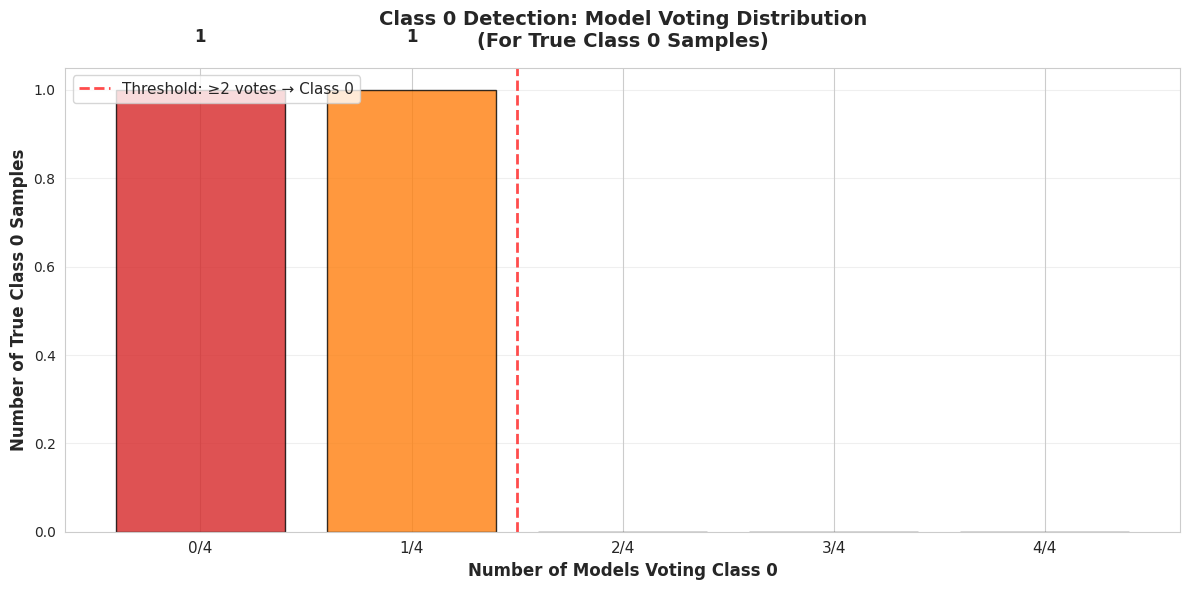


✅ All visualizations generated successfully!


In [11]:
# ============================================================================
# CELL 10.5: VISUALIZATION - CONFUSION MATRIX AND PERFORMANCE PLOTS
# ============================================================================
print("\n" + "="*80)
print("📊 GENERATING VISUALIZATIONS")
print("="*80)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['font.size'] = 10

# Create figure with subplots
fig = plt.figure(figsize=(20, 15))

# ============================================================================
# 1. CONFUSION MATRIX (Main)
# ============================================================================
print("\n📈 Creating confusion matrix visualization...")

ax1 = plt.subplot(3, 3, (1, 5))
cm = confusion_matrix(y_val_final, y_val_pred_final)

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[config.CLASS_NAMES[i] for i in sorted(np.unique(y_val_final))],
            yticklabels=[config.CLASS_NAMES[i] for i in sorted(np.unique(y_val_final))],
            cbar_kws={'label': 'Count'},
            ax=ax1)

ax1.set_title('Confusion Matrix - Validation Set\nEnsemble with Class 0 Boosting',
              fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.setp(ax1.get_yticklabels(), rotation=0, fontsize=9)

# ============================================================================
# 2. NORMALIZED CONFUSION MATRIX
# ============================================================================
print("📈 Creating normalized confusion matrix...")

ax2 = plt.subplot(3, 3, (3, 6))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn',
            xticklabels=[config.CLASS_NAMES[i] for i in sorted(np.unique(y_val_final))],
            yticklabels=[config.CLASS_NAMES[i] for i in sorted(np.unique(y_val_final))],
            cbar_kws={'label': 'Proportion'},
            vmin=0, vmax=1,
            ax=ax2)

ax2.set_title('Normalized Confusion Matrix\n(Row-wise Normalization)',
              fontsize=14, fontweight='bold', pad=20)
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.setp(ax2.get_yticklabels(), rotation=0, fontsize=9)

# ============================================================================
# 3. PER-CLASS F1 SCORES
# ============================================================================
print("📈 Creating per-class F1 score bar chart...")

ax3 = plt.subplot(3, 3, 7)
f1_per_class = f1_score(y_val_final, y_val_pred_final, average=None, zero_division=0)
available_classes = sorted(np.unique(y_val_final))
class_labels_short = [config.CLASS_NAMES[int(i)][:15] for i in available_classes]

colors = ['#d62728' if f1 < 0.5 else '#ff7f0e' if f1 < 0.7 else '#2ca02c'
          for f1 in f1_per_class]

bars = ax3.bar(range(len(f1_per_class)), f1_per_class, color=colors, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Class', fontsize=11, fontweight='bold')
ax3.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
ax3.set_title('F1 Score per Class', fontsize=12, fontweight='bold', pad=10)
ax3.set_xticks(range(len(f1_per_class)))
ax3.set_xticklabels(class_labels_short, rotation=45, ha='right', fontsize=9)
ax3.set_ylim([0, 1])
ax3.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold: 0.5')
ax3.axhline(y=f1_macro, color='blue', linestyle='--', alpha=0.7,
            label=f'Macro Avg: {f1_macro:.3f}')
ax3.legend(fontsize=9)
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, f1_val) in enumerate(zip(bars, f1_per_class)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{f1_val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# ============================================================================
# 4. PRECISION, RECALL, F1 PER CLASS
# ============================================================================
print("📈 Creating precision/recall/F1 comparison...")

ax4 = plt.subplot(3, 3, 8)
precision_per_class = precision_score(y_val_final, y_val_pred_final, average=None, zero_division=0)
recall_per_class = recall_score(y_val_final, y_val_pred_final, average=None, zero_division=0)

x = np.arange(len(available_classes))
width = 0.25

bars1 = ax4.bar(x - width, precision_per_class, width, label='Precision',
                color='#1f77b4', alpha=0.8, edgecolor='black')
bars2 = ax4.bar(x, recall_per_class, width, label='Recall',
                color='#ff7f0e', alpha=0.8, edgecolor='black')
bars3 = ax4.bar(x + width, f1_per_class, width, label='F1-Score',
                color='#2ca02c', alpha=0.8, edgecolor='black')

ax4.set_xlabel('Class', fontsize=11, fontweight='bold')
ax4.set_ylabel('Score', fontsize=11, fontweight='bold')
ax4.set_title('Precision, Recall, F1-Score per Class', fontsize=12, fontweight='bold', pad=10)
ax4.set_xticks(x)
ax4.set_xticklabels(class_labels_short, rotation=45, ha='right', fontsize=9)
ax4.legend(fontsize=9, loc='lower right')
ax4.set_ylim([0, 1.1])
ax4.grid(axis='y', alpha=0.3)

# ============================================================================
# 5. CLASS DISTRIBUTION
# ============================================================================
print("📈 Creating class distribution comparison...")

ax5 = plt.subplot(3, 3, 9)
true_counts = [np.sum(y_val_final == cls) for cls in available_classes]
pred_counts = [np.sum(y_val_pred_final == cls) for cls in available_classes]

x = np.arange(len(available_classes))
width = 0.35

bars1 = ax5.bar(x - width/2, true_counts, width, label='True Distribution',
                color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax5.bar(x + width/2, pred_counts, width, label='Predicted Distribution',
                color='#e74c3c', alpha=0.8, edgecolor='black')

ax5.set_xlabel('Class', fontsize=11, fontweight='bold')
ax5.set_ylabel('Count', fontsize=11, fontweight='bold')
ax5.set_title('True vs Predicted Class Distribution', fontsize=12, fontweight='bold', pad=10)
ax5.set_xticks(x)
ax5.set_xticklabels(class_labels_short, rotation=45, ha='right', fontsize=9)
ax5.legend(fontsize=9)
ax5.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{int(height)}',
                 ha='center', va='bottom', fontsize=8)

# ============================================================================
# Add overall metrics text box
# ============================================================================
metrics_text = f"""
OVERALL METRICS (Validation Set)

Accuracy:              {accuracy:.4f}
F1 Score (Macro):      {f1_macro:.4f} ⭐
F1 Score (Weighted):   {f1_weighted:.4f}
Precision (Macro):     {precision:.4f}
Recall (Macro):        {recall:.4f}
Cohen's Kappa:         {kappa:.4f}

CV Mean F1:            {cv_scores.mean():.4f} ± {cv_scores.std():.4f}

Total Validation Samples: {len(y_val_final)}
"""

fig.text(0.02, 0.98, metrics_text,
         transform=fig.transFigure,
         fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         family='monospace')

plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save figure
viz_path = os.path.join(config.OUTPUT_PATH, 'validation_visualization.png')
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"\n💾 Visualization saved to: {viz_path}")

plt.show()

print("\n" + "="*80)
print("✅ VISUALIZATIONS COMPLETE")
print("="*80)

# ============================================================================
# ADDITIONAL: Individual Model Comparison
# ============================================================================
print("\n📊 Creating individual model comparison...")

fig2, axes = plt.subplots(2, 2, figsize=(16, 12))
fig2.suptitle('Individual Model Confusion Matrices', fontsize=16, fontweight='bold', y=1.00)

for idx, (model, name, ax) in enumerate(zip(config.INDIVIDUAL_MODELS, config.MODEL_NAMES, axes.flat)):
    y_pred_individual = model.predict(X_val_scaled_final)
    cm_individual = confusion_matrix(y_val_final, y_pred_individual)

    sns.heatmap(cm_individual, annot=True, fmt='d', cmap='Blues',
                xticklabels=[config.CLASS_NAMES[i] for i in sorted(np.unique(y_val_final))],
                yticklabels=[config.CLASS_NAMES[i] for i in sorted(np.unique(y_val_final))],
                ax=ax)

    f1_individual = f1_score(y_val_final, y_pred_individual, average='macro')
    acc_individual = accuracy_score(y_val_final, y_pred_individual)

    ax.set_title(f'{name}\nF1 Macro: {f1_individual:.4f} | Accuracy: {acc_individual:.4f}',
                 fontsize=12, fontweight='bold', pad=10)
    ax.set_ylabel('True Label', fontsize=10, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=10, fontweight='bold')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=8)

plt.tight_layout()

# Save individual models figure
viz_path_individual = os.path.join(config.OUTPUT_PATH, 'individual_models_comparison.png')
plt.savefig(viz_path_individual, dpi=300, bbox_inches='tight')
print(f"💾 Individual models visualization saved to: {viz_path_individual}")

plt.show()

# ============================================================================
# ADDITIONAL: Class 0 Detection Analysis
# ============================================================================
if np.sum(y_val_final == 0) > 0:
    print("\n📊 Creating Class 0 detection analysis...")

    fig3, ax = plt.subplots(1, 1, figsize=(12, 6))

    class_0_indices = np.where(y_val_final == 0)[0]
    class_0_votes = []

    for idx in class_0_indices:
        votes = sum([pred[idx] == 0 for pred in individual_predictions])
        class_0_votes.append(votes)

    vote_counts = [class_0_votes.count(i) for i in range(5)]

    bars = ax.bar(range(5), vote_counts, color=['#d62728', '#ff7f0e', '#ffbb78', '#98df8a', '#2ca02c'],
                  edgecolor='black', alpha=0.8)

    ax.set_xlabel('Number of Models Voting Class 0', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of True Class 0 Samples', fontsize=12, fontweight='bold')
    ax.set_title('Class 0 Detection: Model Voting Distribution\n(For True Class 0 Samples)',
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(range(5))
    ax.set_xticklabels(['0/4', '1/4', '2/4', '3/4', '4/4'], fontsize=11)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels
    for i, (bar, count) in enumerate(zip(bars, vote_counts)):
        if count > 0:
            ax.text(bar.get_x() + bar.get_width()/2., count + 0.1,
                   f'{count}',
                   ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Add threshold line
    ax.axvline(x=1.5, color='red', linestyle='--', linewidth=2,
               label='Threshold: ≥2 votes → Class 0', alpha=0.7)
    ax.legend(fontsize=11, loc='upper left')

    plt.tight_layout()

    viz_path_class0 = os.path.join(config.OUTPUT_PATH, 'class0_detection_analysis.png')
    plt.savefig(viz_path_class0, dpi=300, bbox_inches='tight')
    print(f"💾 Class 0 analysis saved to: {viz_path_class0}")

    plt.show()

print("\n✅ All visualizations generated successfully!")

#**TEXT DATASET**

In [15]:
# ============================================================================
# CELL 11: LOAD TEST DATASET (FIXED)
# ============================================================================
print("\n" + "="*80)
print("TEST DATASET PROCESSING")
print("="*80)

# ⭐ CRITICAL FIX: Ensure model reference is correct
model = hubert_model_original  # Make sure 'model' variable is set
print(f"✅ Model reference restored: {type(model)}")

# Define paths
TEST_BASE_PATH = '/content/drive/MyDrive/SAND_Challenge_task1_test_dataset/task1'
TEST_EXCEL_PATH = os.path.join(TEST_BASE_PATH, 'sand_task1_test.xlsx')
TEST_AUDIO_PATH = os.path.join(TEST_BASE_PATH, 'test')

print(f"\n[1/4] Loading test dataset...")
print(f"  Base path: {TEST_BASE_PATH}")
print(f"  Excel path: {TEST_EXCEL_PATH}")
print(f"  Audio path: {TEST_AUDIO_PATH}")

# Verify paths
print(f"\n📁 Verifying test data structure...")
print(f"  Base folder exists: {os.path.exists(TEST_BASE_PATH)}")
print(f"  Excel file exists: {os.path.exists(TEST_EXCEL_PATH)}")
print(f"  Audio folder exists: {os.path.exists(TEST_AUDIO_PATH)}")

# List audio folders
if os.path.exists(TEST_AUDIO_PATH):
    audio_folders = sorted([f for f in os.listdir(TEST_AUDIO_PATH)
                          if os.path.isdir(os.path.join(TEST_AUDIO_PATH, f))])
    print(f"  Audio folders found: {audio_folders}")
else:
    print(f"  ⚠ Audio path not found! Please check the folder structure.")

# ============================================================================
# CELL 12: LOAD TEST DATASET INFO (UNCHANGED)
# ============================================================================
print(f"\n[2/4] Loading test dataset information...")

# Load test dataset info
df_test = pd.read_excel(TEST_EXCEL_PATH)
print(f"  ✅ Loaded {len(df_test)} test samples")

# Display test dataset structure
print(f"\n📊 Test Dataset Info:")
print(f"  Columns: {list(df_test.columns)}")
print(f"  Number of samples: {len(df_test)}")

print(f"\n  Sample IDs (first 10):")
for idx in range(min(10, len(df_test))):
    excel_id = df_test.iloc[idx]['ID']
    filename_id = f"ID{str(excel_id).zfill(3)}"
    print(f"    Excel: {excel_id} -> Filename: {filename_id}")

# Audio types for test
TEST_AUDIO_TYPES = ['phonationA', 'phonationE', 'phonationI', 'phonationO', 'phonationU',
                    'rhythmKA', 'rhythmPA', 'rhythmTA']
print(f"\n  Expected audio types: {TEST_AUDIO_TYPES}")

# ============================================================================
# CELL 13: EXTRACT FEATURES FROM TEST DATASET (FIXED)
# ============================================================================
print(f"\n[3/4] Extracting features from test dataset...")
print(f"  Processing {len(df_test)} test samples")
print(f"  Total audio files: {len(df_test) * len(TEST_AUDIO_TYPES)}")

def extract_features_for_test_dataset(df, test_audio_path, audio_types):
    """
    Extract HuBERT + Spectral features for test dataset
    """
    features_list = []
    ids_list = []
    failed_samples = []

    print(f"\n  Processing test samples...")

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="  Extracting"):
        try:
            excel_id = row['ID']
            filename_id = f"ID{str(excel_id).zfill(3)}"
            patient_features = []
            missing_files = []

            # Process all audio types for this patient
            for audio_type in audio_types:
                audio_file = f"{filename_id}_{audio_type}.wav"
                audio_path = os.path.join(test_audio_path, audio_type, audio_file)

                if os.path.exists(audio_path):
                    try:
                        # Load audio
                        audio, sr = load_audio(
                            audio_path,
                            target_sr=config.SAMPLING_RATE,
                            max_length=config.MAX_AUDIO_LENGTH
                        )

                        # Extract HuBERT features
                        hubert_features = extract_hubert_features(
                            audio,
                            sampling_rate=sr,
                            pooling=config.POOLING_STRATEGY
                        )

                        # Extract spectral features
                        spectral_features = extract_spectral_features(audio, sr)

                        # Concatenate features
                        combined_features = np.concatenate([hubert_features, spectral_features])
                        patient_features.append(combined_features)

                    except Exception as e:
                        print(f"\n  ⚠ Error processing {audio_file}: {str(e)}")
                        missing_files.append(audio_type)
                        # Use zero features
                        feature_dim = model.config.hidden_size
                        if config.POOLING_STRATEGY == 'mean+max':
                            feature_dim *= 2
                        feature_dim += 9
                        patient_features.append(np.zeros(feature_dim))
                else:
                    missing_files.append(audio_type)
                    # Use zero features for missing files
                    feature_dim = model.config.hidden_size
                    if config.POOLING_STRATEGY == 'mean+max':
                        feature_dim *= 2
                    feature_dim += 9
                    patient_features.append(np.zeros(feature_dim))

            if missing_files:
                print(f"\n  ⚠ Patient {filename_id}: Missing {missing_files}")

            # Concatenate features from all audio types
            combined_features = np.concatenate(patient_features)
            features_list.append(combined_features)
            ids_list.append(excel_id)

        except Exception as e:
            print(f"\n  ❌ Failed to process patient {excel_id}: {str(e)}")
            import traceback
            traceback.print_exc()
            failed_samples.append(excel_id)
            continue

    X = np.array(features_list)
    ids = np.array(ids_list)

    if failed_samples:
        print(f"\n  ⚠ Failed samples: {failed_samples}")

    print(f"\n  ✅ Successfully processed {len(ids)} out of {len(df)} samples")

    return X, ids

# Extract features for test set
print("\n🎵 Extracting TEST features...")
X_test, ids_test = extract_features_for_test_dataset(
    df_test,
    TEST_AUDIO_PATH,
    TEST_AUDIO_TYPES
)

print(f"\n✅ Test feature extraction complete!")
print(f"  Test features: X={X_test.shape}")
print(f"  Test IDs: {len(ids_test)}")
print(f"  Expected: {len(df_test)} samples")

# Verify we got all samples
if len(ids_test) != len(df_test):
    print(f"  ⚠ WARNING: Only {len(ids_test)} out of {len(df_test)} samples processed!")
    print(f"  Missing IDs:")
    missing_ids = set(df_test['ID'].values) - set(ids_test)
    for mid in sorted(missing_ids):
        print(f"    - {mid}")
else:
    print(f"  ✅ All samples processed successfully!")

# Clean and standardize test features
print(f"\n🔧 Preprocessing test features...")
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
X_test_scaled = scaler.transform(X_test)
print(f"  ✅ Test features standardized")
print(f"    Mean: {X_test_scaled.mean():.6f}, Std: {X_test_scaled.std():.6f}")

# Clear GPU memory
torch.cuda.empty_cache()

print(f"\n✅ Ready for predictions on test set!")


TEST DATASET PROCESSING
✅ Model reference restored: <class 'transformers.models.hubert.modeling_hubert.HubertModel'>

[1/4] Loading test dataset...
  Base path: /content/drive/MyDrive/SAND_Challenge_task1_test_dataset/task1
  Excel path: /content/drive/MyDrive/SAND_Challenge_task1_test_dataset/task1/sand_task1_test.xlsx
  Audio path: /content/drive/MyDrive/SAND_Challenge_task1_test_dataset/task1/test

📁 Verifying test data structure...
  Base folder exists: True
  Excel file exists: True
  Audio folder exists: True
  Audio folders found: ['phonationA', 'phonationE', 'phonationI', 'phonationO', 'phonationU', 'rhythmKA', 'rhythmPA', 'rhythmTA']

[2/4] Loading test dataset information...
  ✅ Loaded 67 test samples

📊 Test Dataset Info:
  Columns: ['ID', 'Age', 'Sex', 'Class']
  Number of samples: 67

  Sample IDs (first 10):
    Excel: 4 -> Filename: ID004
    Excel: 11 -> Filename: ID011
    Excel: 14 -> Filename: ID014
    Excel: 19 -> Filename: ID019
    Excel: 20 -> Filename: ID020
 

  Extracting:   0%|          | 0/67 [00:00<?, ?it/s]


  ✅ Successfully processed 67 out of 67 samples

✅ Test feature extraction complete!
  Test features: X=(67, 6216)
  Test IDs: 67
  Expected: 67 samples
  ✅ All samples processed successfully!

🔧 Preprocessing test features...
  ✅ Test features standardized
    Mean: -0.001018, Std: 0.981228

✅ Ready for predictions on test set!


In [16]:
# ============================================================================
# CELL 14: PREDICT ON TEST DATASET AND CREATE SUBMISSION CSV
# ============================================================================
print(f"\n[4/4] Making predictions on test dataset...")

# Get predictions from ensemble
print(f"\n🎯 Running ensemble prediction...")
y_test_pred_ensemble = classifier.predict(X_test_scaled)
y_test_proba_ensemble = classifier.predict_proba(X_test_scaled)

# Get individual model predictions for Class 0 boosting
print(f"\n📊 Getting individual model predictions...")
individual_test_predictions = []

for model_clf, name in zip(config.INDIVIDUAL_MODELS, config.MODEL_NAMES):
    pred = model_clf.predict(X_test_scaled)
    individual_test_predictions.append(pred)
    class_0_count = np.sum(pred == 0)
    print(f"   {name}: predicted {class_0_count} Class 0 samples")

print(f"   Ensemble: predicted {np.sum(y_test_pred_ensemble == 0)} Class 0 samples")

# Apply aggressive Class 0 detection rule
print(f"\n🚀 Applying Class 0 boosting rule...")
y_test_pred_final = y_test_pred_ensemble.copy()

for i in range(len(y_test_pred_final)):
    # Count how many models predicted Class 0 for this sample
    class_0_votes = sum([pred[i] == 0 for pred in individual_test_predictions])

    if class_0_votes >= 2:  # If 2 or more models say Class 0
        y_test_pred_final[i] = 0

final_class_0_count = np.sum(y_test_pred_final == 0)
print(f"   Final Class 0 predictions: {final_class_0_count}")

# Convert predictions back to 1-indexed for submission
y_test_pred_submission = y_test_pred_final + 1

# Create submission DataFrame with ORIGINAL Excel IDs
submission_df = pd.DataFrame({
    'ID': ids_test,  # Original IDs from Excel (4, 11, 14, etc.)
    'CLASS': y_test_pred_submission
})

# Display prediction distribution
print(f"\n📊 Prediction Distribution:")
pred_counts = pd.Series(y_test_pred_submission).value_counts().sort_index()
for cls in range(1, 6):
    count = pred_counts.get(cls, 0)
    pct = (count / len(submission_df)) * 100
    class_name = config.CLASS_NAMES[cls - 1]
    print(f"   Class {cls} ({class_name}): {count:3d} ({pct:5.2f}%)")

# Save submission CSV
submission_path = os.path.join(config.OUTPUT_PATH, 'submission.csv')
submission_df.to_csv(submission_path, index=False)

print(f"\n✅ Submission file created!")
print(f"   📁 Path: {submission_path}")
print(f"   📊 Samples: {len(submission_df)}")
print(f"\n📋 Sample of submission file:")
print(submission_df.head(10))

# Verify submission format
print(f"\n🔍 Verifying submission format...")
checks = []
checks.append(("File extension", submission_path.endswith('.csv')))
checks.append(("Column count", len(submission_df.columns) == 2))
checks.append(("Column names", list(submission_df.columns) == ['ID', 'CLASS']))
checks.append(("Number of rows", len(submission_df) == len(df_test)))
checks.append(("Class range", submission_df['CLASS'].min() >= 1 and submission_df['CLASS'].max() <= 5))
checks.append(("ID match", all(submission_df['ID'].values == df_test['ID'].values)))

print("\n   Validation checks:")
for check_name, result in checks:
    status = "✅" if result else "❌"
    print(f"      {status} {check_name}: {result}")

if all([c[1] for c in checks]):
    print(f"\n🎉 Submission file is valid and ready for submission!")
else:
    print(f"\n⚠️ Submission file has validation errors!")

# Save detailed test predictions
test_results_df = submission_df.copy()
test_results_df['Ensemble_Prediction'] = y_test_pred_ensemble + 1
test_results_df['Final_Prediction'] = y_test_pred_submission

# Add individual model predictions
for i, name in enumerate(config.MODEL_NAMES):
    test_results_df[f'{name}_Prediction'] = individual_test_predictions[i] + 1

# Save detailed results
detailed_path = os.path.join(config.OUTPUT_PATH, 'test_predictions_detailed.csv')
test_results_df.to_csv(detailed_path, index=False)
print(f"\n💾 Detailed predictions saved to: {detailed_path}")

print("\n" + "="*80)
print("✅ TEST DATASET PROCESSING COMPLETE!")
print("="*80)
print(f"\n📁 Output files:")
print(f"   1. {submission_path}")
print(f"   2. {detailed_path}")
print(f"\n🚀 Ready for submission to SAND Challenge!")


[4/4] Making predictions on test dataset...

🎯 Running ensemble prediction...

📊 Getting individual model predictions...
   Balanced SVM: predicted 0 Class 0 samples
   Weighted SVM: predicted 0 Class 0 samples
   RF: predicted 0 Class 0 samples
   LogReg: predicted 0 Class 0 samples
   Ensemble: predicted 0 Class 0 samples

🚀 Applying Class 0 boosting rule...
   Final Class 0 predictions: 0

📊 Prediction Distribution:
   Class 1 (Severe Dysarthria):   0 ( 0.00%)
   Class 2 (Moderate Dysarthria):   6 ( 8.96%)
   Class 3 (Mild Dysarthria):  19 (28.36%)
   Class 4 (No Dysarthria (ALS)):   6 ( 8.96%)
   Class 5 (Healthy):  36 (53.73%)

✅ Submission file created!
   📁 Path: /content/drive/MyDrive/SAND_Project_Data/hubert_baseline_results/submission.csv
   📊 Samples: 67

📋 Sample of submission file:
   ID  CLASS
0   4      5
1  11      3
2  14      3
3  19      5
4  20      5
5  22      4
6  31      3
7  32      5
8  39      4
9  43      5

🔍 Verifying submission format...

   Validation c